# Demo on using spiking data to evaluate alexnet layers

In this demo, we will use the RDMs from demo_spikes to compare to the layers of Alexnet. 

For this illustration, we use the data by [Cadena et al. (2019)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006897) . Before running this demo you need to download this data from here: [https://doi.org/10.12751/g-node.2e31e3](https://doi.org/10.12751/g-node.2e31e3) . Simply download as a zip and unpack. Inside you will find a file called `data_binned_responses/cadena_ploscb_data.pkl`. Copy this file into the same folder as this demo notebook.

Additionally you will need the following packages installed and we will import them now:

In [1]:
# imports
import pickle as pkl
import numpy as np
import rsatoolbox
import matplotlib.pyplot as plt
import torchvision
import torch
import PIL
import tqdm

The following cell loads the data and computes the RDMs based on the description in demo_spikes. Here, we compute one for each subject. You can have a look there to find other ways of computing RDMs.

In [2]:
# computing the RDMs as in demo_spikes:
# loading the data
with open('cadena_ploscb_data.pkl', 'rb') as f:
    data_raw = pkl.load(f)
# reshaping
responses = np.reshape(data_raw['responses'], (4*7250, 166))
image_ids = np.repeat(data_raw['image_ids'], 4, 1).T.flatten()
image_types = np.repeat(data_raw['image_types'], 4, 1).T.flatten()
image_numbers = np.repeat(data_raw['image_numbers'], 4, 1).T.flatten()
repetition = np.repeat([np.arange(4)], 7250, 0).T.flatten()
# removing NaN rows
idx_ok = ~np.any(np.isnan(responses), 1)
responses = responses[idx_ok]
image_ids = image_ids[idx_ok]
image_types = [str(i) for i in image_types[idx_ok]]
image_numbers = image_numbers[idx_ok]
repetition = repetition[idx_ok]
# creating the Dataset object:
data = rsatoolbox.data.Dataset(
    responses,
    descriptors=None,
    obs_descriptors={
        'image_ids': image_ids,
        'image_types': image_types,
        'image_numbers': image_numbers,
        'repetition': repetition
    },
    channel_descriptors={
        'subject_id': data_raw['subject_id'],
        'session_id': data_raw['session_id'],
        'unit_id': data_raw['unit_id'],
    },
)
rdm_overall = rsatoolbox.rdm.calc_rdm(data.split_channel('subject_id'), method='poisson', descriptor='image_ids')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


# Now we need to generate the models objects for the Alexnet layers
As a first step we download alexnet:

In [3]:
alexnet = torchvision.models.alexnet(weights='DEFAULT')
# deactivate gradients as we will never need them
alexnet.eval()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Now, we need to extract the activations of the Alexnet layers for the images we are interested in. The images are part of the data_raw dictionary in the data. To extract activations we use hooks attached to the layers of Alexnet in this demo. There are other ways of extracting the activations from deep neural networks and even a number of packages focussed on this problem. For example, see TorchLense, net2brain, or THINGSvision.

In this field we define the hook, which just attaches the last output of a module to it as module.output.
Additionally, we define a few functions to preprocess images before they enter alexnet. These steps depend on the given neural network and the tools you use for extracting the activations. To use the toolbox just make sure that you end up with a numpy array for each layer:

In [4]:
def hook(module, input, output):
    module.output = output

images = data_raw['images']
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
def preprocess(im):
    stimulus = PIL.Image.fromarray(im)
    stimulus = stimulus.resize((224, 224))
    stimulus = stimulus.convert('RGB')
    stimulus = np.array(stimulus).transpose(2, 0, 1)
    if stimulus.shape[0] == 4:
        stimulus = stimulus[:3]
    stimulus = torch.tensor(stimulus, dtype=torch.float) / 255
    stimulus = normalize(stimulus)
    stimulus = torch.unsqueeze(stimulus, 0)
    return stimulus
    

# register hook for each layer:
for l in alexnet.features:
    l.register_forward_hook(hook)


Now we can run the extraction to get the activations for each layer and compute RDMs for them. Usually, we would show these steps separately, but the features in Alexnet for 6250 images are quite large, such that most users won't be able to store all activations in memory at the same time on their local machine for demos. Thus, we run everything sequentially for the different fetures. For the first layers this is still not tiny (~10Gb), but this should work for most current PCs.

There are two steps, which we perform for each layer: First, we run Alexnet for the images and extract the activations. Then we create a Dataset object and compute the RDM, just as we did for the data. Performing these steps for all layers and images takes a while. Feel free to grab a coffee or tea.

In [5]:
feat_rdms = [None] * len(alexnet.features)
feat_models = [None] * len(alexnet.features)
# run for first image to set output for the first time:
alexnet(preprocess(images[0]))

for idx, l in enumerate(alexnet.features):
    # get all activations
    print("extracting activations")
    # preallocate
    activations = np.zeros(np.concatenate([[len(images[idx_ok[:7250]])], l.output.shape[1:]]))
    for im_idx, im in tqdm.tqdm(enumerate(images[idx_ok[:7250]])):
        stimulus = preprocess(im)
        alexnet(stimulus)
        activations[im_idx] = l.output[0].detach().numpy()
    print("calculating RDM")
    data_set = rsatoolbox.data.Dataset(
        np.reshape(activations,[activations.shape[0], np.prod(activations.shape[1:])]),
        obs_descriptors={'image_ids': data_raw['image_ids'][idx_ok[:7250]]}
    )
    feat_rdms[idx] = rsatoolbox.rdm.calc_rdm(data_set)
    feat_models[idx] = rsatoolbox.model.ModelFixed(str(idx), feat_rdms[idx])
    print(f"finished feature layer {idx}")

extracting activations


6250it [01:02, 100.38it/s]


calculating RDM
finished feature layer 0
extracting activations


6250it [01:03, 98.89it/s] 


calculating RDM
finished feature layer 1
extracting activations


6250it [01:02, 100.35it/s]


calculating RDM
finished feature layer 2
extracting activations


6250it [01:02, 99.40it/s] 


calculating RDM
finished feature layer 3
extracting activations


6250it [01:03, 98.90it/s] 


calculating RDM
finished feature layer 4
extracting activations


6250it [01:01, 101.21it/s]


calculating RDM
finished feature layer 5
extracting activations


6250it [01:01, 101.98it/s]


calculating RDM
finished feature layer 6
extracting activations


6250it [01:01, 102.00it/s]


calculating RDM
finished feature layer 7
extracting activations


6250it [01:01, 102.31it/s]


calculating RDM
finished feature layer 8
extracting activations


6250it [01:01, 102.40it/s]


calculating RDM
finished feature layer 9
extracting activations


6250it [01:01, 102.19it/s]


calculating RDM
finished feature layer 10
extracting activations


6250it [01:01, 102.00it/s]


calculating RDM
finished feature layer 11
extracting activations


6250it [01:00, 102.65it/s]


calculating RDM
finished feature layer 12


## running the inference:

The simplest case is "eval_fixed", which evaluates the predictions on the measured data, but performs neither fitting, cross-validation, nor bootstrapping. Tests are then based on t-tests over the RDM dimension, i.e. across the two monkeys in our case:

In [6]:
result = rsatoolbox.inference.eval_fixed(data=rdm_overall, models=feat_models, method="corr")

(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

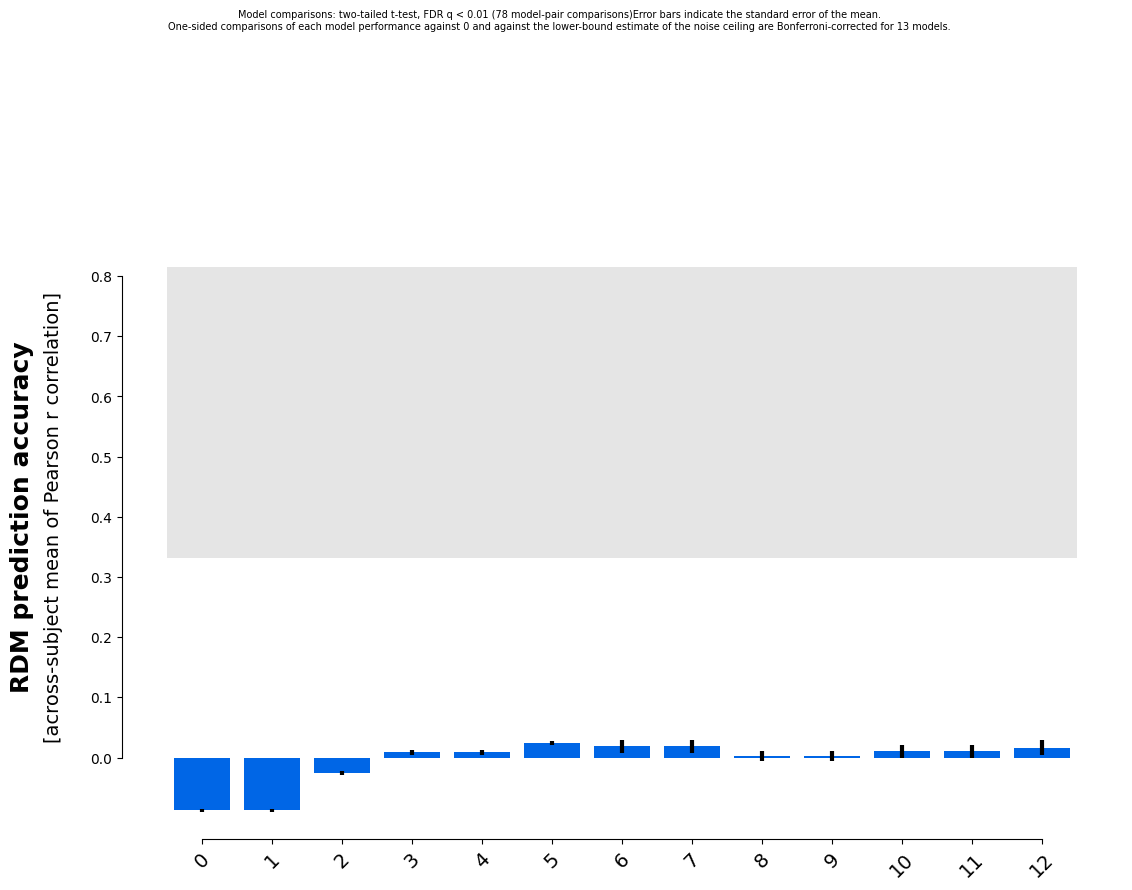

In [7]:
rsatoolbox.vis.plot_model_comparison(result)

To address generalization to new stimuli, we can instead run a stimulus bootstrap as follows. This runs the evaluation N times. To avoid long waiting here, we reduced the number of samples here. In actual applications, you probably want to wait for at least the 1000 samples to ensure that the results do not depend on a lucky bootstrapping draw.

In [8]:
result_boot = rsatoolbox.inference.eval_bootstrap_pattern(data=rdm_overall, models=feat_models, method="corr", N=25)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:09<00:00,  9.99s/it]


(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

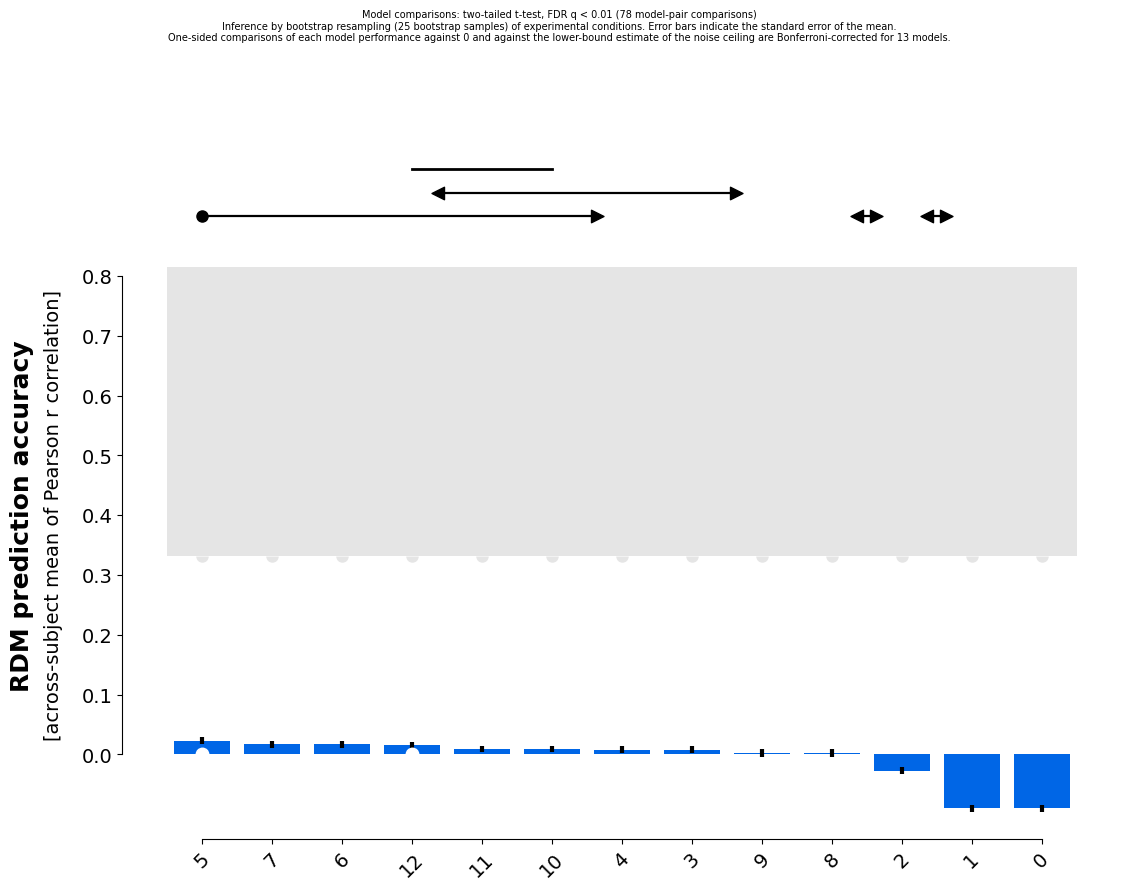

In [9]:
rsatoolbox.vis.plot_model_comparison(result_boot, sort=True)